<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

**Цель:** Спрогнозировать количество заказов такси на следующий час.

**Задача:** Построить модель для предсказания заказов такси, у которой значение метрики *RMSE* на тестовой выборке будет не больше 48.

**Ход работы:**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами.
4. Проверить данные на тестовой выборке и сделать выводы.

**Описание данных:**
 - `datetime` - время заказов
 - `num_orders` - количество заказов


In [1]:
!pip install lightgbm

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import warnings


warnings.filterwarnings('ignore')
RANDOM_STATE = 42

## Подготовка

In [3]:
taxi = pd.read_csv('C:/FATHER/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
taxi.head() 

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
taxi.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [6]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Выполним ресемплирование данных по одному часу.

In [7]:
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
taxi.shape

(4416, 1)

**Вывод:** В исходных данных 26496 записей. Мы выполнили ресемплирование по одному часу и сложили количество заказов. В получившихся данных 4416 записей.

## Анализ

In [9]:
taxi['rolling_mean'] = taxi['num_orders'].rolling(100).mean()
taxi_day = taxi.resample('1D').sum()
taxi_day['rolling_mean'] = taxi_day['rolling_mean'].rolling(10).mean()

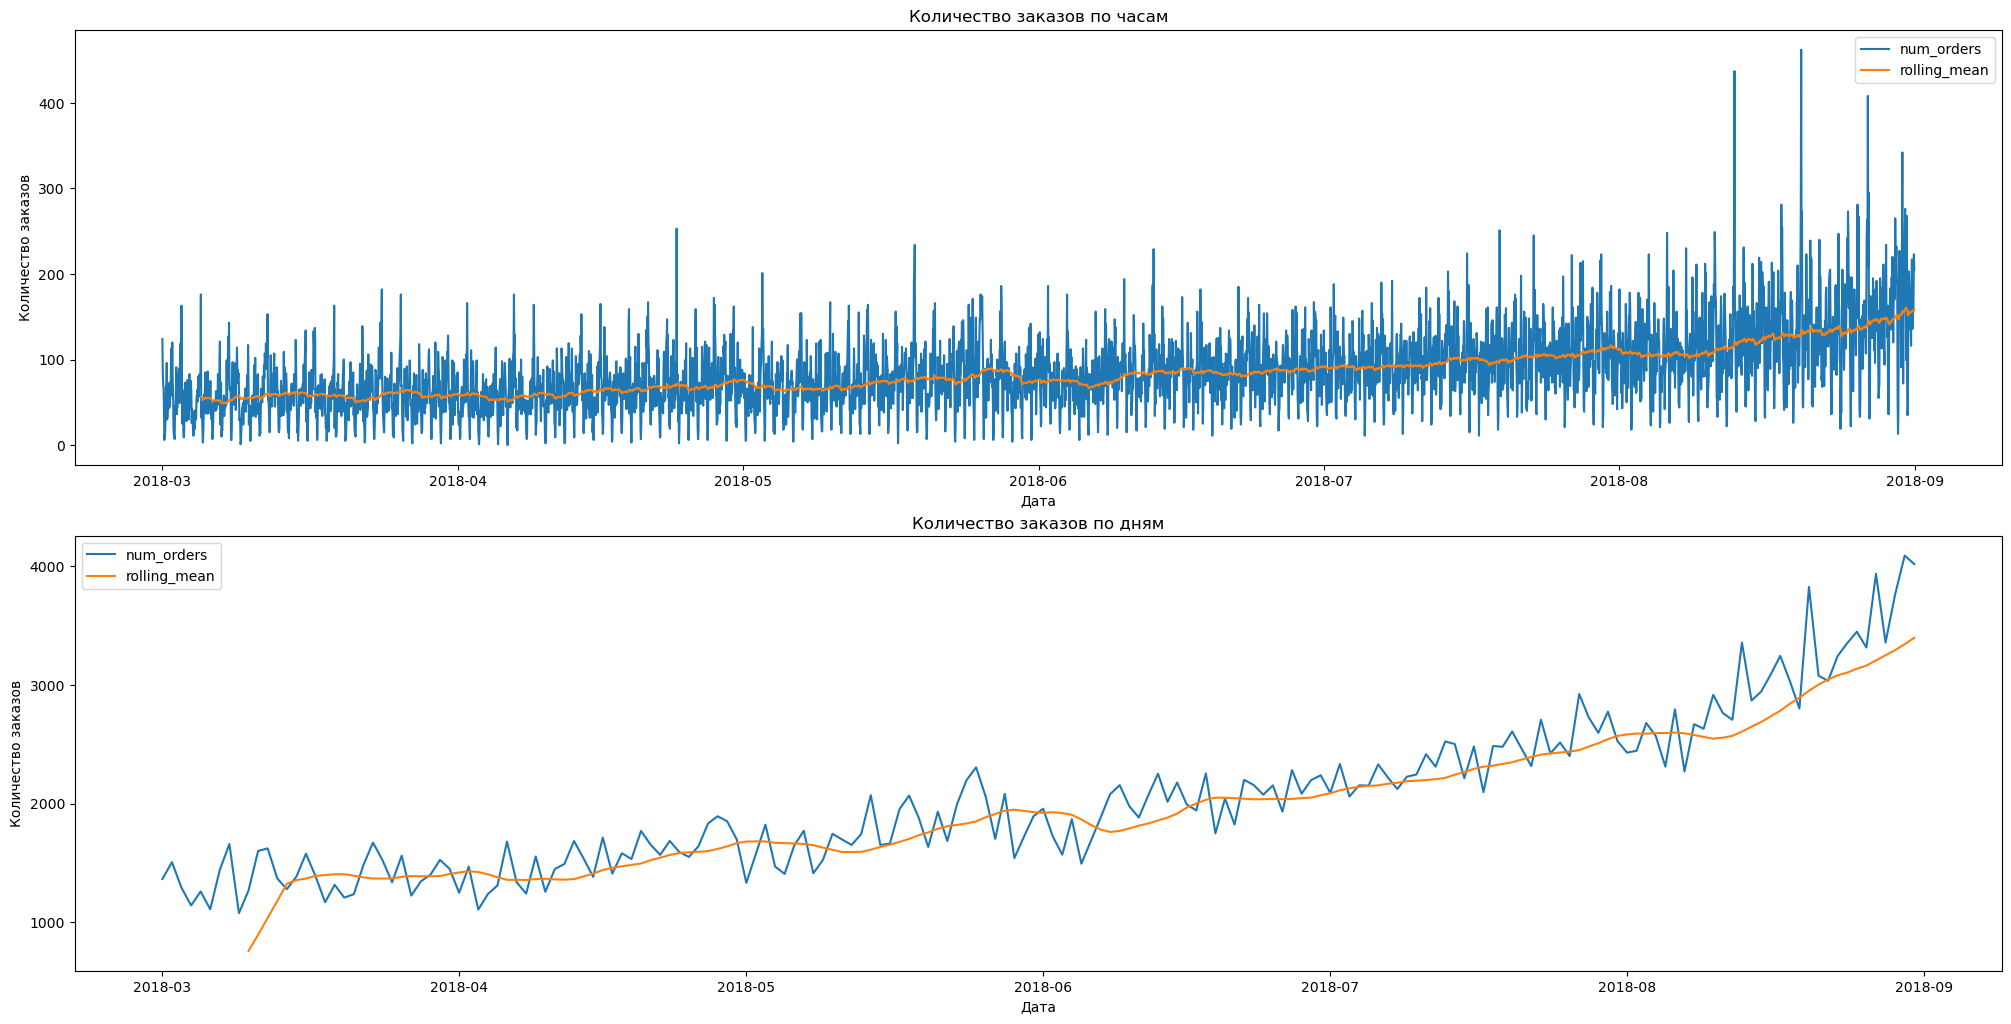

In [10]:
fig, axs = plt.subplots(nrows= 2 , ncols= 1 )
fig.set_size_inches(20, 10)
fig.tight_layout(h_pad= 3)

axs[0].plot(taxi)
axs[0].set_ylabel('Количество заказов')
axs[0].set_xlabel('Дата')
axs[0].set_title('Количество заказов по часам')
axs[0].legend(('num_orders', 'rolling_mean'))

axs[1].plot(taxi_day)
axs[1].set_ylabel('Количество заказов')
axs[1].set_xlabel('Дата')
axs[1].set_title('Количество заказов по дням')
axs[1].legend (('num_orders', 'rolling_mean'))

plt.rc('font', size= 20 ) 
plt.show()

In [11]:
taxi = taxi.drop('rolling_mean',axis=1)
p_taxi = taxi['2018-03-01':'2018-03-8']
decomposed = seasonal_decompose(p_taxi)

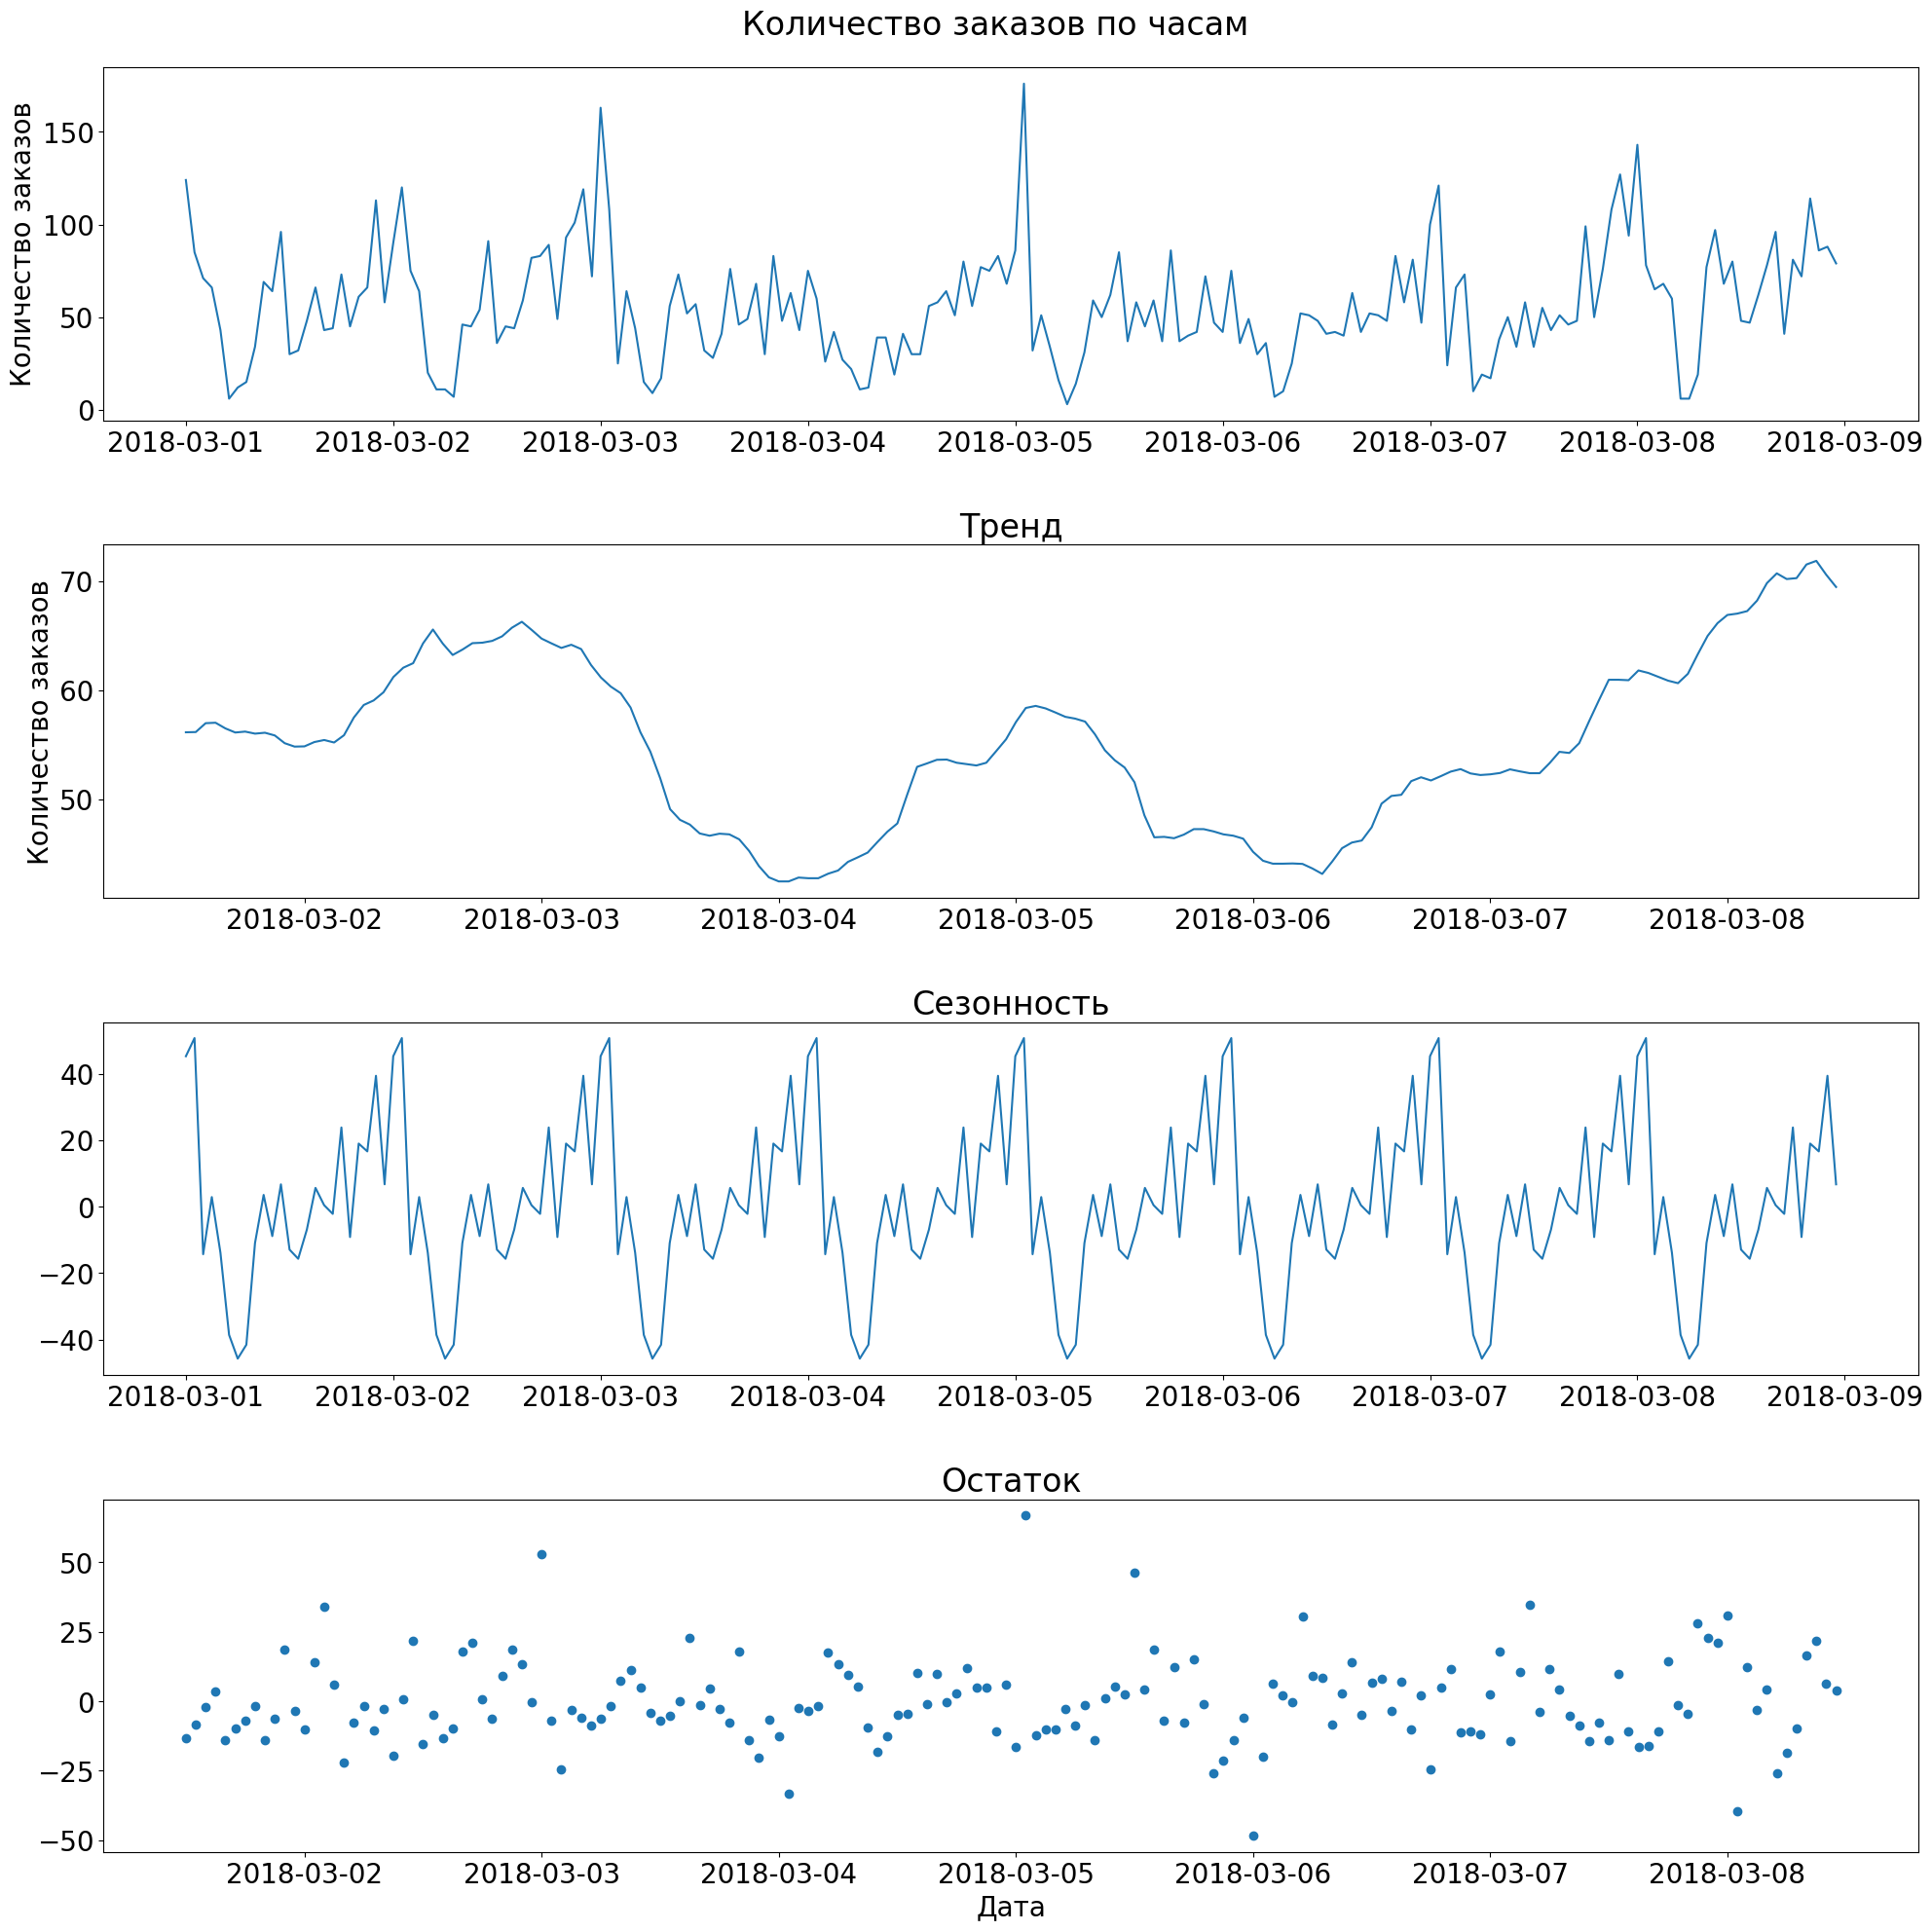

In [12]:
fig, axs = plt.subplots(nrows= 4 , ncols= 1 )
fig.set_size_inches(20, 20)
fig.tight_layout(h_pad= 3)

axs[0].plot(p_taxi)
axs[0].set_ylabel('Количество заказов')

axs[1].plot(decomposed.trend)
axs[1].set_ylabel('Количество заказов')
axs[1].set_title('Тренд')

axs[2].plot(decomposed.seasonal)
axs[2].set_title('Сезонность')

axs[3].scatter(decomposed.resid.index,decomposed.resid )
axs[3].set_title('Остаток')
axs[3].set_xlabel('Дата')

plt.suptitle('Количество заказов по часам')
plt.subplots_adjust(top= 0.95 )
plt.rc('font', size= 20 ) 
plt.show()

In [13]:
taxi_day = taxi_day.drop('rolling_mean', axis=1)
decomposed_day = seasonal_decompose(taxi_day)

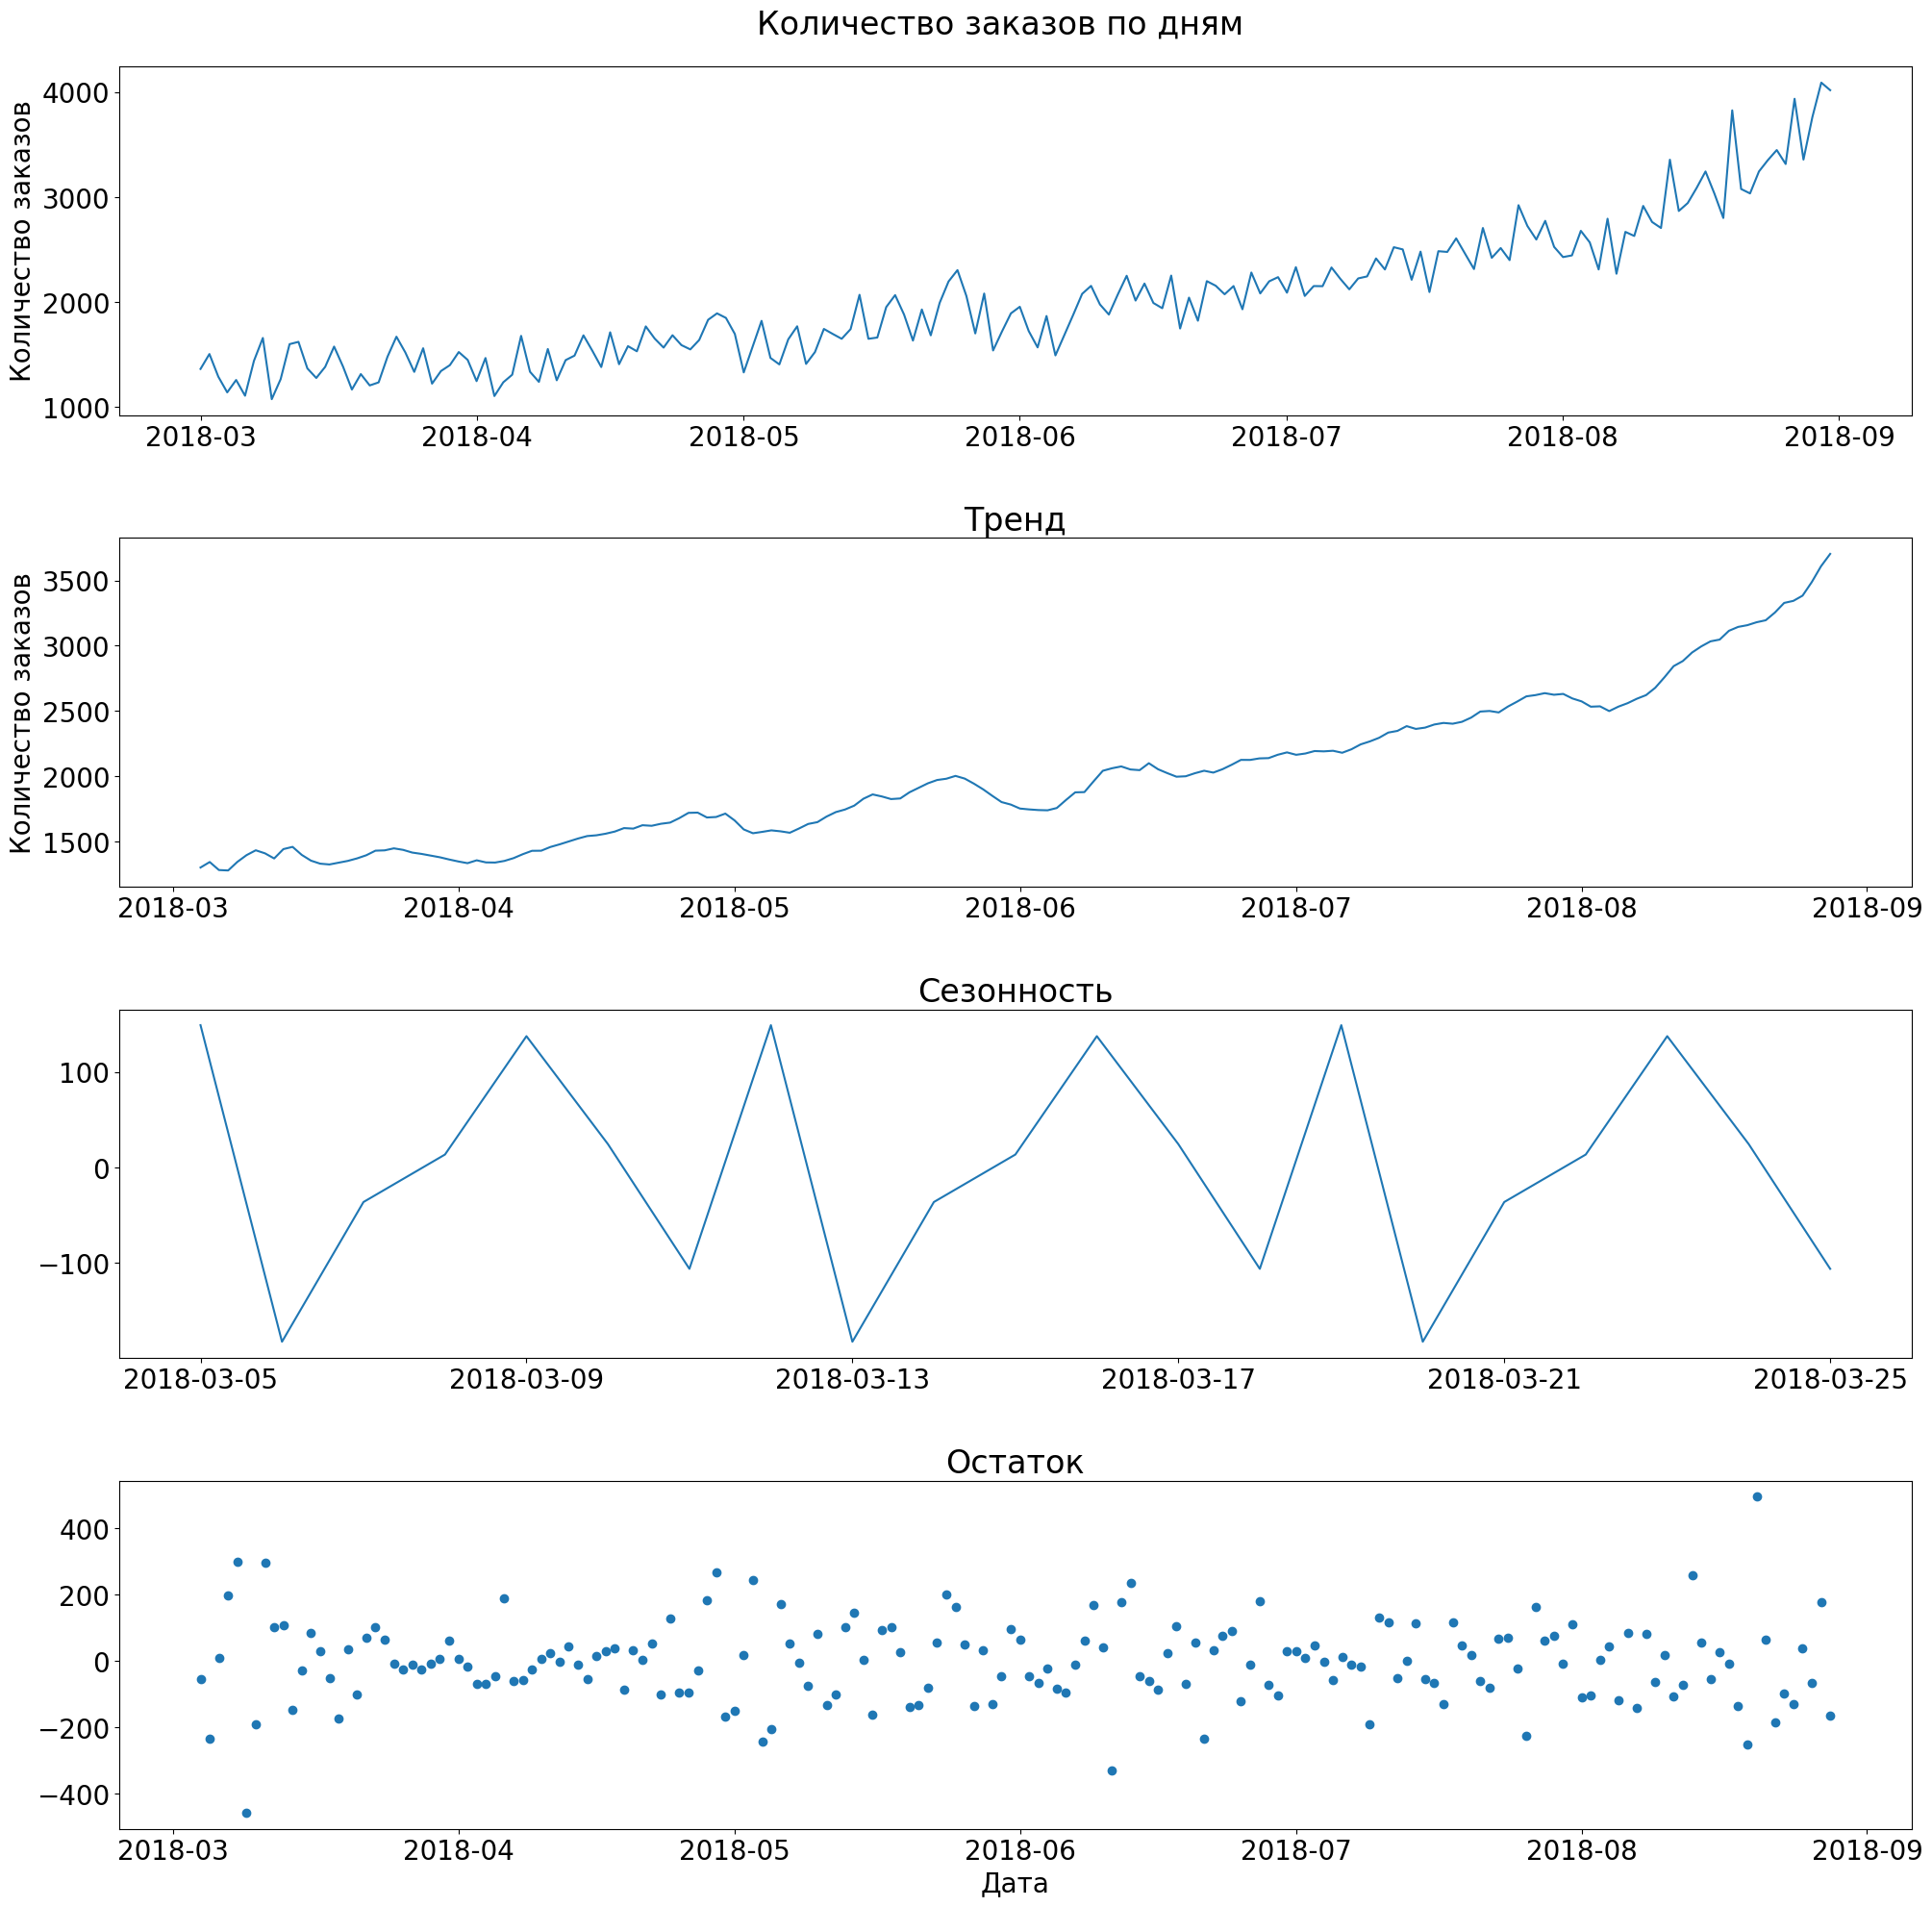

In [14]:
fig, axs = plt.subplots(nrows= 4 , ncols= 1 )
fig.set_size_inches(20, 20)
fig.tight_layout(h_pad= 3)

axs[0].plot(taxi_day)
axs[0].set_ylabel('Количество заказов')

axs[1].plot(decomposed_day.trend)
axs[1].set_ylabel('Количество заказов')
axs[1].set_title('Тренд')

axs[2].plot(decomposed_day.seasonal['2018-03-05':'2018-03-25'])
axs[2].set_title('Сезонность')

axs[3].scatter(decomposed_day.resid.index,decomposed_day.resid )
axs[3].set_title('Остаток')
axs[3].set_xlabel('Дата')

plt.suptitle('Количество заказов по дням')
plt.subplots_adjust(top= 0.95 )
plt.rc('font', size= 20 ) 
plt.show()

Проверим ряд на стационарность. Проведем тесты ADF и KPSS. Сформулируем гипотезы для первого теста.

Нулевая гипотеза: Ряд имеет единичный корень, ряд нестационарен.

Альтернативная гипотеза: Ряд не имеет единичного корня, стационарен.

In [15]:
test_adf = adfuller(taxi)
alpha = 0.01
p_value = test_adf[1]
print('p-value:', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.028940051402613506
Не получилось отвергнуть нулевую гипотезу


Для понимания сезонности и лага построим графики ACF и PACF.

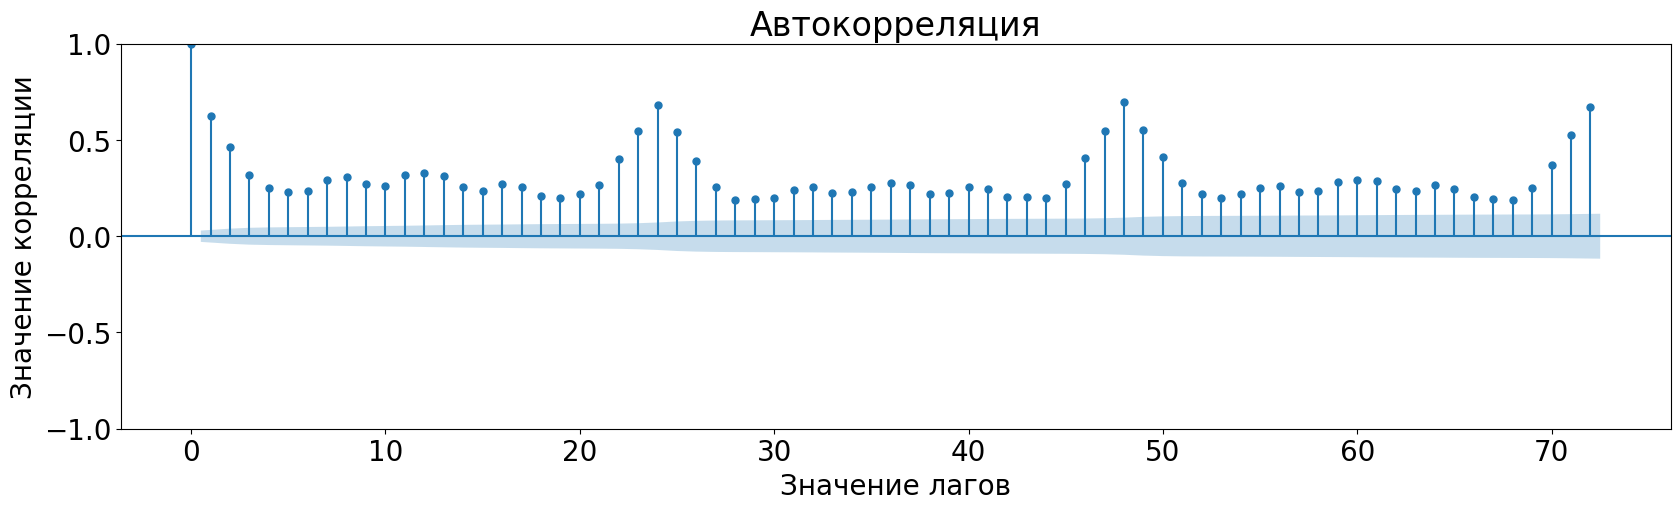

In [16]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))
plot_acf(taxi, ax, lags = 24*3)
plt.xlabel('Значение лагов')
plt.ylabel('Значение корреляции')
plt.title('Автокорреляция')
plt.show()

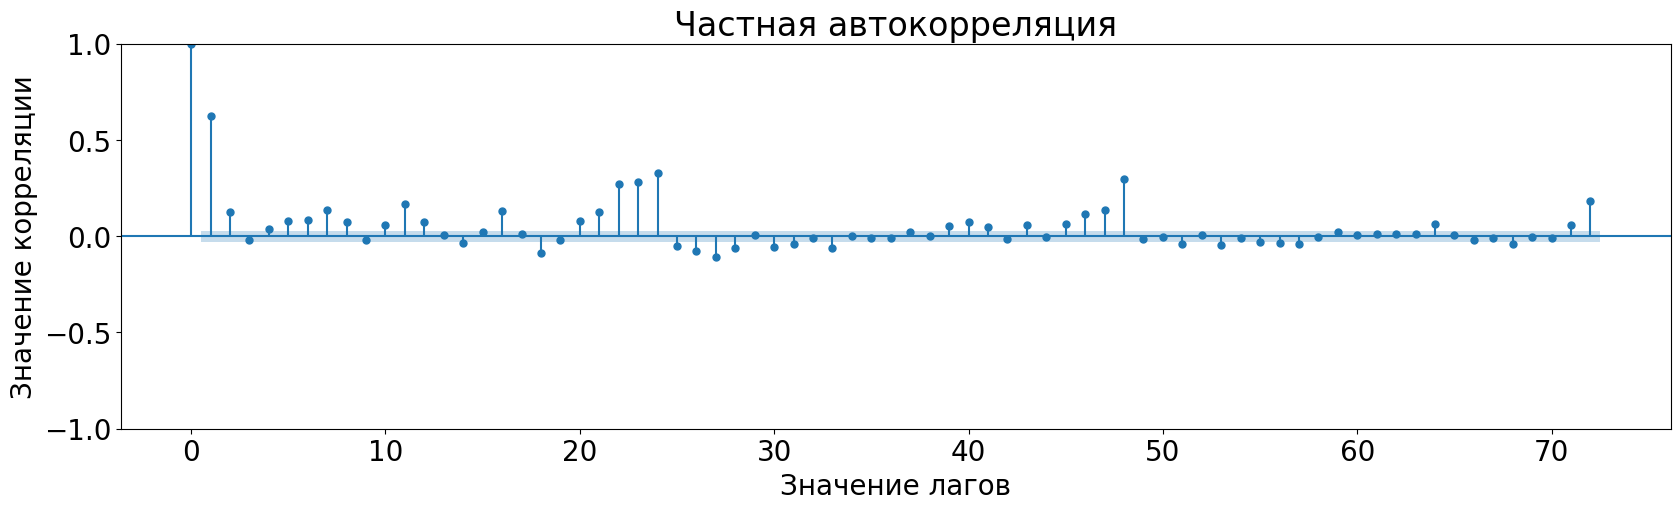

In [17]:
fig, ax = plt.subplots(1,1, figsize=(20, 5))
plot_pacf(taxi, ax, lags = 24*3)
plt.xlabel('Значение лагов')
plt.ylabel('Значение корреляции')
plt.title('Частная автокорреляция')
plt.show()

**Вывод:**

По проведенному анализу можно сделать слеующие выводы:
1. Количество заказов такси растет с марта по сентябрь
2. Пик количества заказов наблюдается в августе
3. Количество заказов каждый день мансимально ночью и минимально утром
4. Количество заказов увеличивается каждую пятницу и понедельник
5. Наш временной ряд нестационарен.
6. Графики автокорреляции подтверждают сезонность. Количество заказов увеличивается каждые 24 часа.

## Обучение

### Создание признаков

Добавим в датасет календарные признаки: день, месяц, день недели, час, - "отстающие знаяения" и "скользящее среднее".

In [18]:
def creat_feature(data, max_lag, rm_size):
    df = data.copy()
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag+1):
        df['lag_'+str(lag)] = df['num_orders'].shift(lag)
        
    df['rolling_mean'] = df['lag_1'].rolling(rm_size).mean()
    
    return df

In [19]:
taxi2 = creat_feature(taxi, 24, 24)

Удалим пропуски.

In [20]:
taxi2 = taxi2.dropna()
taxi2.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,0,58.0,113.0,66.0,61.0,45.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,3,2,4,1,90.0,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,3,2,4,2,120.0,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


### Обучение моделей

In [21]:
X_train, X_test, y_train, y_test = train_test_split(taxi2.drop('num_orders', axis=1),
                                                    taxi2['num_orders'], shuffle=False, test_size=0.1)

In [22]:
lr = LinearRegression()
rmse_lr = round(-cross_val_score(lr, X_train, y_train, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit()).mean(),1)
print('Значение RMSE линейной регрессии:', rmse_lr)

Значение RMSE линейной регрессии: 26.9


In [23]:
def fit_models(model, param):
    grid = GridSearchCV(model, param, scoring = 'neg_root_mean_squared_error', cv=TimeSeriesSplit(), n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_
    best_score = grid.best_score_
    print('Лучшие параметры модели:', best_params)
    print('Значение RMSE дерева решений:', round(-best_score,1))
    
    return grid.best_estimator_

In [24]:
tr = DecisionTreeRegressor(random_state=RANDOM_STATE)
param_tr = {'max_depth':[None] + [i for i in range(2, 7)] ,'min_samples_leaf':[3,4,5,6,7]}

best_model_tr = fit_models(tr, param_tr)

Лучшие параметры модели: {'max_depth': 5, 'min_samples_leaf': 6}
Значение RMSE дерева решений: 29.4


In [25]:
lgbm = LGBMRegressor(n_jobs=-1, random_state=RANDOM_STATE)
param_lgbm = {'num_leaves':[50, 60],'n_estimators': [200, 500],'max_depth':[None, 5,7] }

best_model_lgbm = fit_models(lgbm, param_lgbm)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4877
[LightGBM] [Info] Number of data points in the train set: 3952, number of used features: 29
[LightGBM] [Info] Start training from score 78.451417
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

**Вывод:**

Мы обучили три модели: `LinearRegression`, `DecisionTreeRegressor`, `LGBMRegressor`. По метрике RMSE на тренировочной выборке лучшей оказалась модель девера решений с градиентным бустингом.

## Тестирование

Проверим работу модели `LGBMRegressor`  на тестовых данных.

In [26]:
pred = best_model_lgbm.predict(X_test)
rmse_lgbm = round(mean_squared_error(y_test, pred, squared=False),1)
print('Значение RMSE на тестовых данных:', rmse_lgbm)

Значение RMSE на тестовых данных: 39.7


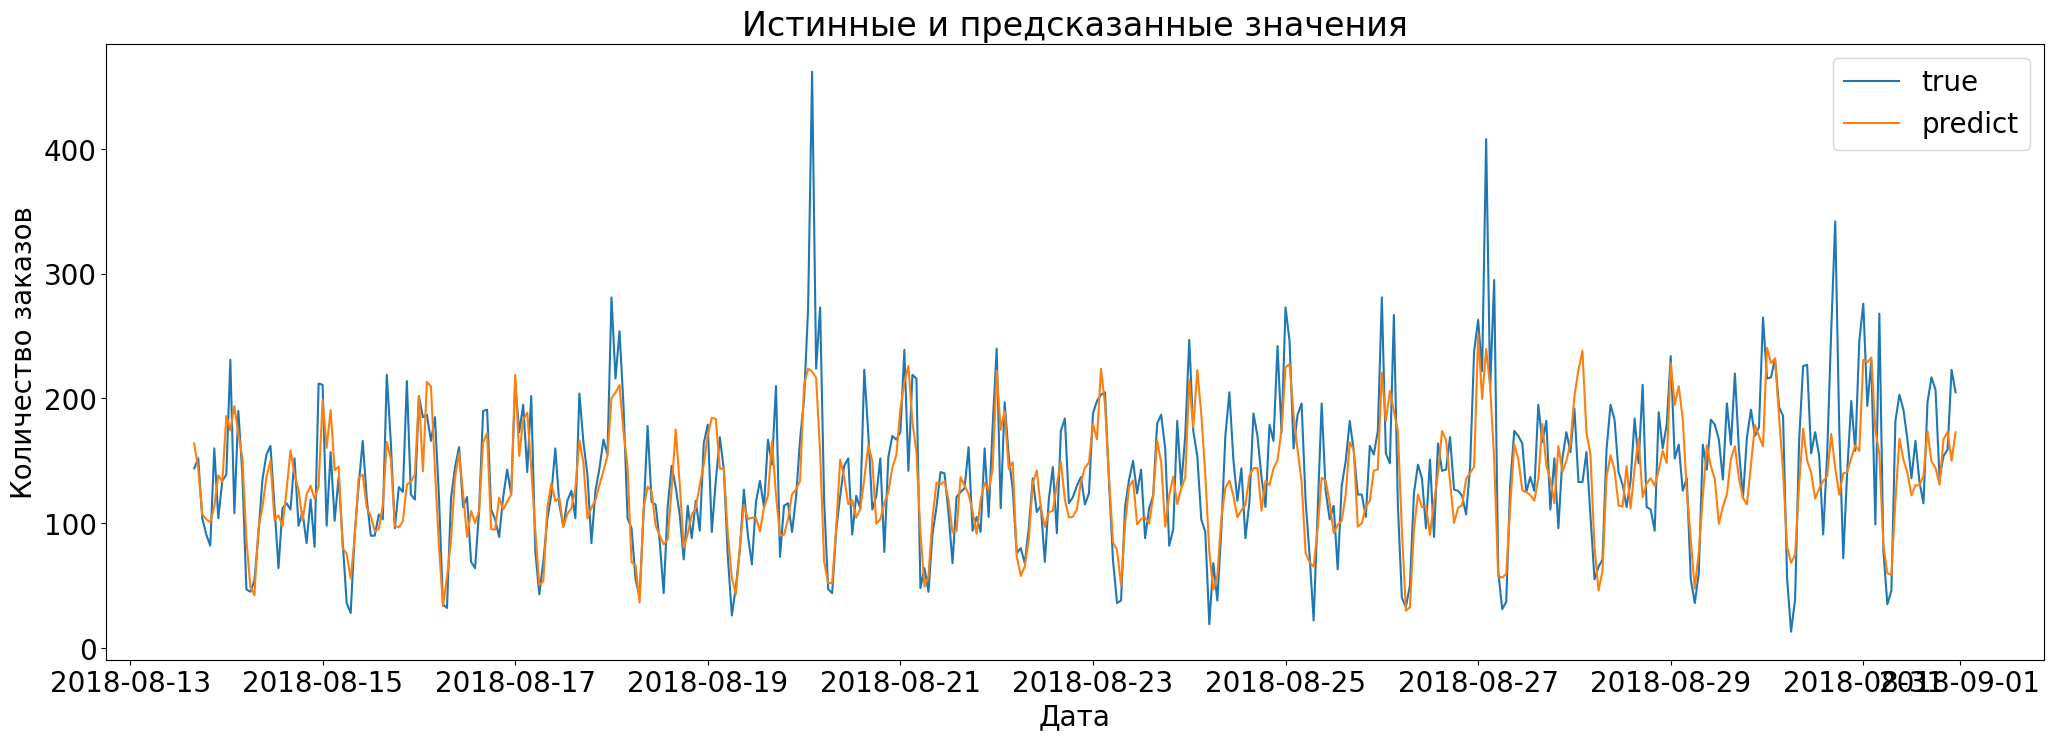

In [27]:
data = pd.DataFrame(data={'true':y_test,'pred':pred})

plt.figure(figsize=(25,8))
plt.plot(data)
plt.legend(('true', 'predict'))
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Истинные и предсказанные значения')
plt.show()

## Общий вывод

В начале работы мы загрузили и проанализировали данные. Построили графики зависимости количества заказов по часам и по дням от времени, сделали декомпозицию рядов по часам и дням, провели ADF тест и построили графики ACF и PACF. По результатам анализа следали следующие выводы:
1. Количество заказов такси растет с марта по сентябрь
2. Пик количества заказов наблюдается в августе
3. Количество заказов каждый день мансимально ночью и минимально утром
4. Количество заказов увеличивается каждую пятницу и понедельник
5. Наш временной ряд нестационарен.
6. Графики автокорреляции подтверждают сезонность. Количество заказов увеличивается каждые 24 часа.

Далее мы создали новые признаки: месяц, день, день недели, час, 24 лага и скользящее среднее окном размера 24. Затем обучили три модели и получили метрику `RMSE` на тренировочной выборке:
1. ` LinearRegression`. `RMSE` - 26.9
2. `DecisionTreeRegressor` с параметрами `'max_depth': 5, 'min_samples_leaf': 6`. `RMSE` - 29.4
3. `LGBMRegressor` с параметрами `'max_depth': 5, 'n_estimators': 200, 'num_leaves': 50`. `RMSE` - 24.8

Лучшую метрику показала модель дерева реший с градиентным бустингом. Мы проверили ее работу на тестовых данных. `RMSE` на тастовой выборке составляет 39.7. Это удовлетворяет условию, что метрика должна быть меньше 48. Сравнив истинные и предсказанные значения на графике, мы можем отметить, что модель не угадывает аномальные значения, но общую закономерность предсказывает верно.